# Tutorial: Algoritmos Genéticos para Job Shop Scheduling

## Introducción al Problema

En este tutorial resolveremos el **Job Shop Scheduling Problem (JSSP)**, un problema clásico de optimización donde debemos:
- Programar **varios trabajos** (jobs)
- Cada trabajo tiene **varias operaciones** que deben hacerse en **orden secuencial**
- Cada operación requiere una **máquina específica** y tiene una **duración determinada**
- **Objetivo:** Minimizar el tiempo total de terminación (makespan)

### Conceptos Clave de Algoritmos Genéticos:

#### 🧬 **Cromosoma (Chromosome)**
Un **cromosoma** es una solución completa al problema. En nuestro caso, un cromosoma representa **un orden completo de todas las operaciones**.

**Ejemplo de cromosoma:**
```python
[('J1', 0), ('J2', 0), ('J1', 1), ('J3', 0), ('J2', 1), ...]
```
Este cromosoma dice: "Primero hacer operación 0 de J1, luego operación 0 de J2, etc."

#### 🧬 **Gen (Gene)**
Un **gen** es una parte individual del cromosoma. En nuestro caso, cada gen es una tupla `(job, operation_index)` que representa una operación específica.

**Ejemplo de gen:**
```python
('J1', 0)  # Operación 0 del trabajo J1
('J2', 1)  # Operación 1 del trabajo J2
```

---

## Definición del Problema

Tenemos:
- **5 trabajos** (J1, J2, J3, J4, J5)
- **3 máquinas** (M1, M2, M3)
- Cada trabajo tiene 3 operaciones que deben hacerse en orden
- Cada operación especifica: (máquina_requerida, duración)

**Ejemplo:** J1 tiene 3 operaciones:
1. Operación 0: Usar M1 por 3 unidades de tiempo
2. Operación 1: Usar M2 por 2 unidades de tiempo
3. Operación 2: Usar M3 por 2 unidades de tiempo

In [1]:
import random
from collections import defaultdict

# ============================================================
# DEFINICIÓN DEL PROBLEMA
# ============================================================

# Definición de trabajos y sus operaciones: (máquina, duración)
# Cada trabajo (job) tiene una lista de operaciones que deben hacerse EN ORDEN
# Formato: 'JobID': [(máquina, duración), (máquina, duración), ...]
jobs = {
    'J1': [('M1', 3), ('M2', 2), ('M3', 2)],  # J1: M1(3) → M2(2) → M3(2)
    'J2': [('M2', 2), ('M1', 4), ('M3', 3)],  # J2: M2(2) → M1(4) → M3(3)
    'J3': [('M3', 3), ('M2', 3), ('M1', 2)],  # J3: M3(3) → M2(3) → M1(2)
    'J4': [('M1', 2), ('M3', 1), ('M2', 4)],  # J4: M1(2) → M3(1) → M2(4)
    'J5': [('M2', 4), ('M3', 3), ('M1', 3)]   # J5: M2(4) → M3(3) → M1(3)
}

# Lista de máquinas disponibles
machines = ['M1', 'M2', 'M3']

# ============================================================
# CREAR LISTA DE TODAS LAS OPERACIONES
# ============================================================

# Lista total de operaciones codificadas como (job_id, operation_index)
# Esta lista representa todos los "genes" posibles que pueden estar en un cromosoma
all_operations = []

# Para cada trabajo y sus operaciones
for job, ops in jobs.items():
    # Para cada índice de operación (0, 1, 2, ...)
    for idx in range(len(ops)):
        # Añadir la tupla (job, índice_operación) a la lista
        # Esto crea un "gen" que representa esta operación específica
        all_operations.append((job, idx))

print("Total de operaciones (genes):", len(all_operations))
print("\nEjemplo de genes:")
for i, op in enumerate(all_operations[:5]):
    job, idx = op
    machine, duration = jobs[job][idx]
    print(f"  Gen {i}: {op} → Usar {machine} por {duration} unidades")

Total de operaciones (genes): 15

Ejemplo de genes:
  Gen 0: ('J1', 0) → Usar M1 por 3 unidades
  Gen 1: ('J1', 1) → Usar M2 por 2 unidades
  Gen 2: ('J1', 2) → Usar M3 por 2 unidades
  Gen 3: ('J2', 0) → Usar M2 por 2 unidades
  Gen 4: ('J2', 1) → Usar M1 por 4 unidades


## Construcción del Cronograma

### ¿Qué es un Cronograma?

Un **cronograma** (schedule) toma un cromosoma (orden de operaciones) y calcula:
- Cuándo empieza cada operación
- Cuándo termina cada operación

### Restricciones:
1. **Restricción de precedencia:** Las operaciones de un mismo trabajo deben hacerse en orden
2. **Restricción de máquina:** Una máquina solo puede hacer una operación a la vez

### Makespan:
El **makespan** es el tiempo total hasta que todos los trabajos terminan (queremos minimizarlo).

In [2]:
# ============================================================
# FUNCIÓN PARA CONSTRUIR EL CRONOGRAMA
# ============================================================

def build_schedule(individual):
    """
    Construye un cronograma a partir de un cromosoma (individuo).
    
    Args:
        individual: Cromosoma - lista de genes (operaciones) en el orden a ejecutar
                   Ejemplo: [('J1', 0), ('J2', 0), ('J1', 1), ...]
    
    Returns:
        schedule: Diccionario {(job, op_idx): (tiempo_inicio, tiempo_fin)}
    """
    # Diccionario para rastrear cuándo estará listo cada trabajo para su siguiente operación
    # Inicialmente todos los trabajos están listos en el tiempo 0
    job_ready_time = defaultdict(int)
    
    # Diccionario para rastrear cuándo estará libre cada máquina
    # Inicialmente todas las máquinas están libres en el tiempo 0
    machine_ready_time = defaultdict(int)
    
    # Diccionario que almacenará el cronograma final
    schedule = {}

    # Procesar cada operación (gen) del cromosoma en orden
    for (job, op_idx) in individual:
        # Obtener información de esta operación desde la definición del problema
        machine, duration = jobs[job][op_idx]
        
        # Calcular el tiempo de inicio más temprano posible
        # Debe esperar a que:
        #   1. El trabajo esté listo (operación anterior del mismo trabajo terminó)
        #   2. La máquina esté libre (no está procesando otra operación)
        start_time = max(job_ready_time[job], machine_ready_time[machine])
        
        # Calcular el tiempo de finalización
        end_time = start_time + duration

        # Guardar en el cronograma
        schedule[(job, op_idx)] = (start_time, end_time)
        
        # Actualizar cuándo estará listo el trabajo para su siguiente operación
        job_ready_time[job] = end_time
        
        # Actualizar cuándo estará libre la máquina
        machine_ready_time[machine] = end_time

    return schedule

# ============================================================
# FUNCIÓN PARA CALCULAR EL MAKESPAN
# ============================================================

def makespan(schedule):
    """
    Calcula el makespan (tiempo total de finalización) de un cronograma.
    
    Args:
        schedule: Diccionario con tiempos de inicio y fin de cada operación
    
    Returns:
        makespan: El tiempo más grande de finalización (cuando termina todo)
    """
    # Retorna el máximo de todos los tiempos de finalización
    # Este es el momento en que el último trabajo termina
    return max(end for (_, end) in schedule.values())

## Generación de Cromosomas Válidos

### Restricción Importante:
No podemos generar cromosomas completamente aleatorios porque debemos respetar la **precedencia de operaciones**:
- La operación 0 de un trabajo debe venir antes que la operación 1
- La operación 1 debe venir antes que la operación 2
- etc.

### Estrategia de Generación:
1. Empezar con las primeras operaciones de todos los trabajos disponibles
2. Elegir aleatoriamente una operación de las disponibles
3. Después de agregar una operación, hacer disponible la siguiente del mismo trabajo
4. Repetir hasta agregar todas las operaciones


![evolucion](figuras/figura5_crossover_job_scheduling.png)

In [7]:
# ============================================================
# GENERAR CROMOSOMAS (INDIVIDUOS) VÁLIDOS
# ============================================================

def generate_individual():
    """
    Genera un cromosoma válido (orden de operaciones que respeta precedencias).
    
    Un cromosoma es una lista de genes donde cada gen es (job, operation_index).
    
    Returns:
        ops: Lista de operaciones (cromosoma completo)
             Ejemplo: [('J1', 0), ('J2', 0), ('J1', 1), ...]
    """
    # Contador para rastrear qué operación de cada trabajo se ha programado
    # Inicialmente, ninguna operación de ningún trabajo se ha programado
    job_counters = {job: 0 for job in jobs}
    
    # Lista para almacenar el cromosoma (orden de operaciones)
    ops = []
    
    # Lista de operaciones que están actualmente disponibles para programar
    # (sus operaciones anteriores ya fueron programadas)
    pending = []

    # PASO 1: Añadir la primera operación (índice 0) de cada trabajo a pending
    # Estas operaciones no tienen precedencias, así que están disponibles desde el inicio
    for job in jobs:
        pending.append((job, 0))  # Agregar gen (job, operación_0)

    # PASO 2: Mientras haya operaciones pendientes
    while pending:
        # Elegir aleatoriamente una operación de las disponibles
        # Esto da aleatoriedad para crear diferentes cromosomas
        op = random.choice(pending)
        
        # Agregar esta operación (gen) al cromosoma
        ops.append(op)
        
        # Extraer información del gen
        job, idx = op
        
        # Remover esta operación de las pendientes (ya fue programada)
        pending.remove(op)
        
        # Si este trabajo tiene más operaciones después de esta
        if idx + 1 < len(jobs[job]):
            # Hacer disponible la siguiente operación de este trabajo
            # Ahora podemos programar (job, idx+1) porque (job, idx) ya está programada
            pending.append((job, idx + 1))
    
    # Retornar el cromosoma completo (lista de genes en orden)
    return ops

# ============================================================
# CREAR POBLACIÓN INICIAL
# ============================================================

def create_population(size=10):
    """
    Crea una población inicial de cromosomas.
    
    Args:
        size: Número de cromosomas en la población
    
    Returns:
        Lista de cromosomas (individuos)
    """
    # Generar 'size' cromosomas aleatorios pero válidos
    return [generate_individual() for _ in range(size)]

# Demostración
print("Ejemplo de un cromosoma generado:\n")
example_chromosome = generate_individual()
print("Cromosoma (secuencia de genes):")
print(example_chromosome)
print(f"\nLongitud del cromosoma: {len(example_chromosome)} genes")
print(f"(5 trabajos × 3 operaciones cada uno = 15 genes totales)")

# Construir y mostrar cronograma de ejemplo
schedule = build_schedule(example_chromosome)
print(f"\nMakespan de este cromosoma: {makespan(schedule)} unidades de tiempo")

Ejemplo de un cromosoma generado:

Cromosoma (secuencia de genes):
[('J4', 0), ('J1', 0), ('J1', 1), ('J1', 2), ('J5', 0), ('J4', 1), ('J3', 0), ('J4', 2), ('J5', 1), ('J2', 0), ('J3', 1), ('J3', 2), ('J5', 2), ('J2', 1), ('J2', 2)]

Longitud del cromosoma: 15 genes
(5 trabajos × 3 operaciones cada uno = 15 genes totales)

Makespan de este cromosoma: 32 unidades de tiempo


## Operadores Genéticos

### 1. Función de Aptitud (Fitness)

La aptitud mide qué tan bueno es un cromosoma. En este problema:
- **Objetivo:** Minimizar el makespan
- **Fitness:** Negativo del makespan (porque el AG maximiza)
- Mayor fitness = Menor makespan = Mejor solución

### 2. Selección

Selección por torneo: elegir 2 cromosomas aleatorios y quedarse con el mejor.

### 3. Cruce (Crossover)

Combina dos cromosomas padres para crear un hijo:
- Toma un segmento del padre 1
- Completa con genes del padre 2 en orden
- Mantiene validez (respeta precedencias)

### 4. Mutación

Introduce variación intercambiando dos genes del cromosoma.

In [4]:
# ============================================================
# FUNCIÓN DE APTITUD (FITNESS)
# ============================================================

def fitness(individual):
    """
    Calcula la aptitud de un cromosoma.
    
    Args:
        individual: Cromosoma (lista de genes)
    
    Returns:
        fitness: Negativo del makespan (porque el AG maximiza y queremos minimizar)
    """
    # Construir el cronograma para este cromosoma
    schedule = build_schedule(individual)
    
    # Retornar negativo del makespan
    # Si makespan = 15, fitness = -15
    # Si makespan = 20, fitness = -20
    # Entonces fitness de -15 es MEJOR que -15 (menor makespan)
    return -makespan(schedule)

# ============================================================
# SELECCIÓN POR TORNEO
# ============================================================

def selection(population):
    """
    Selecciona un cromosoma usando selección por torneo.
    
    Args:
        population: Lista de cromosomas
    
    Returns:
        Mejor cromosoma de los 2 seleccionados aleatoriamente
    """
    # Seleccionar 2 cromosomas aleatorios
    a, b = random.sample(population, 2)
    
    # Retornar el que tiene mejor fitness (mayor, que significa menor makespan)
    return a if fitness(a) > fitness(b) else b

# ============================================================
# OPERADOR DE CRUCE (CROSSOVER)
# ============================================================

def crossover(p1, p2):
    """
    Crea un cromosoma hijo combinando dos cromosomas padres.
    
    Usa una variante de Order Crossover adaptada para mantener validez.
    
    Args:
        p1: Cromosoma padre 1 (lista de genes)
        p2: Cromosoma padre 2 (lista de genes)
    
    Returns:
        child: Cromosoma hijo (lista de genes)
    """
    # Obtener tamaño del cromosoma (número de genes)
    size = len(p1)
    
    # Seleccionar dos puntos de corte aleatorios y ordenarlos
    cut1, cut2 = sorted(random.sample(range(size), 2))
    
    # Extraer el segmento medio del padre 1
    # Estos genes se heredarán directamente del padre 1
    middle = p1[cut1:cut2]
    
    # Obtener los genes del padre 2 que NO están en el segmento middle
    # Mantiene el orden relativo del padre 2
    remaining = [op for op in p2 if op not in middle]
    
    # Construir el hijo:
    # - Primera parte: genes de p2 (antes del corte)
    # - Parte media: genes de p1 (segmento heredado)
    # - Última parte: genes de p2 (después del corte)
    child = remaining[:cut1] + middle + remaining[cut1:]
    
    return child

# ============================================================
# OPERADOR DE MUTACIÓN
# ============================================================

def mutate(ind, prob=0.2):
    """
    Muta un cromosoma intercambiando dos genes.
    
    Args:
        ind: Cromosoma a mutar
        prob: Probabilidad de mutación (default: 20%)
    
    Returns:
        ind: Cromosoma mutado (o sin cambios)
    """
    # Con probabilidad 'prob', realizar la mutación
    if random.random() < prob:
        # Seleccionar dos posiciones aleatorias diferentes
        i, j = random.sample(range(len(ind)), 2)
        
        # Intercambiar los genes en esas posiciones
        # Esto cambia el orden de ejecución de dos operaciones
        ind[i], ind[j] = ind[j], ind[i]
    
    return ind

# Demostración de operadores
print("Demostración de Operadores Genéticos\n")
print("="*60)

# Crear dos cromosomas padres
p1 = generate_individual()
p2 = generate_individual()

print(f"Padre 1 - Fitness: {fitness(p1)} (makespan: {-fitness(p1)})")
print(f"Padre 2 - Fitness: {fitness(p2)} (makespan: {-fitness(p2)})")

# Cruce
child = crossover(p1, p2)
print(f"\nHijo (cruce) - Fitness: {fitness(child)} (makespan: {-fitness(child)})")

# Mutación
mutated = child.copy()
mutate(mutated, prob=1.0)  # 100% para asegurar que mute
print(f"Hijo mutado - Fitness: {fitness(mutated)} (makespan: {-fitness(mutated)})")

Demostración de Operadores Genéticos

Padre 1 - Fitness: -20 (makespan: 20)
Padre 2 - Fitness: -25 (makespan: 25)

Hijo (cruce) - Fitness: -17 (makespan: 17)
Hijo mutado - Fitness: -21 (makespan: 21)


## Ciclo Evolutivo

El algoritmo genético funciona así:

1. **Inicializar** población de cromosomas aleatorios
2. **Para cada generación:**
   - Crear nueva población vacía
   - Repetir hasta llenar la nueva población:
     - **Seleccionar** dos padres
     - **Cruzar** padres para crear hijo
     - **Mutar** hijo
     - Agregar hijo a nueva población
   - Reemplazar población antigua con nueva
   - Mostrar mejor cromosoma de esta generación
3. **Retornar** el mejor cromosoma encontrado

In [5]:
# ============================================================
# FUNCIÓN DE EVOLUCIÓN
# ============================================================

def evolve(population, generations=30):
    """
    Ejecuta el algoritmo genético.
    
    Args:
        population: Población inicial de cromosomas
        generations: Número de generaciones a evolucionar
    
    Returns:
        best: Mejor cromosoma encontrado
    """
    # Iterar a través de cada generación
    for gen in range(generations):
        # Crear nueva población vacía
        new_pop = []
        
        # Generar tantos hijos como individuos en la población actual
        for _ in range(len(population)):
            # PASO 1: Seleccionar dos padres usando selección por torneo
            p1 = selection(population)
            p2 = selection(population)
            
            # PASO 2: Crear hijo mediante cruce
            child = crossover(p1, p2)
            
            # PASO 3: Aplicar mutación al hijo
            child = mutate(child)
            
            # PASO 4: Agregar hijo a la nueva población
            new_pop.append(child)
        
        # Reemplazar población antigua con nueva generación
        population = new_pop
        
        # Encontrar el mejor cromosoma de esta generación
        # max() con key=fitness encuentra el cromosoma con mayor fitness
        best = max(population, key=fitness)
        
        # Mostrar progreso
        # fitness(best) es negativo, así que -fitness(best) da el makespan real
        print(f"Gen {gen+1:2d} | Makespan: {-fitness(best):.0f}")
    
    # Retornar el mejor cromosoma de la última generación
    return best

# ============================================================
# EJECUTAR EL ALGORITMO GENÉTICO
# ============================================================

print("\n" + "="*60)
print("EJECUTANDO ALGORITMO GENÉTICO")
print("="*60 + "\n")

# Crear población inicial de 10 cromosomas
population = create_population(10)

# Mostrar fitness inicial
initial_makespans = [-fitness(ind) for ind in population]
print(f"Makespan inicial (promedio): {sum(initial_makespans)/len(initial_makespans):.1f}")
print(f"Makespan inicial (mejor): {min(initial_makespans):.0f}")
print("\nEvolucionando...\n")

# Ejecutar evolución por 30 generaciones
best_solution = evolve(population, generations=30)

# Mostrar resultado final
print("\n" + "="*60)
print("MEJOR SOLUCIÓN ENCONTRADA")
print("="*60)
print(f"\nMakespan final: {-fitness(best_solution):.0f} unidades de tiempo")
print(f"\nCromosoma (secuencia de operaciones):")
for i, (job, op_idx) in enumerate(best_solution):
    machine, duration = jobs[job][op_idx]
    print(f"  {i+1:2d}. {job}-Op{op_idx+1}: {machine} por {duration} unidades")


EJECUTANDO ALGORITMO GENÉTICO

Makespan inicial (promedio): 23.8
Makespan inicial (mejor): 17

Evolucionando...

Gen  1 | Makespan: 17
Gen  2 | Makespan: 17
Gen  3 | Makespan: 17
Gen  4 | Makespan: 17
Gen  5 | Makespan: 17
Gen  6 | Makespan: 17
Gen  7 | Makespan: 17
Gen  8 | Makespan: 17
Gen  9 | Makespan: 17
Gen 10 | Makespan: 15
Gen 11 | Makespan: 15
Gen 12 | Makespan: 15
Gen 13 | Makespan: 15
Gen 14 | Makespan: 15
Gen 15 | Makespan: 15
Gen 16 | Makespan: 15
Gen 17 | Makespan: 15
Gen 18 | Makespan: 15
Gen 19 | Makespan: 15
Gen 20 | Makespan: 15
Gen 21 | Makespan: 15
Gen 22 | Makespan: 15
Gen 23 | Makespan: 15
Gen 24 | Makespan: 15
Gen 25 | Makespan: 15
Gen 26 | Makespan: 15
Gen 27 | Makespan: 15
Gen 28 | Makespan: 15
Gen 29 | Makespan: 15
Gen 30 | Makespan: 15

MEJOR SOLUCIÓN ENCONTRADA

Makespan final: 15 unidades de tiempo

Cromosoma (secuencia de operaciones):
   1. J1-Op1: M1 por 3 unidades
   2. J3-Op1: M3 por 3 unidades
   3. J5-Op1: M2 por 4 unidades
   4. J2-Op1: M2 por 2 un

## Visualización: Diagrama de Gantt

Un **Diagrama de Gantt** muestra visualmente el cronograma:
- Eje X: Tiempo
- Eje Y: Máquinas
- Barras: Operaciones (cada color representa un trabajo diferente)

Esto nos permite ver:
- Cuándo cada máquina está ocupada
- Cuándo hay tiempo muerto
- El makespan total


Diagrama de Gantt de la mejor solución:



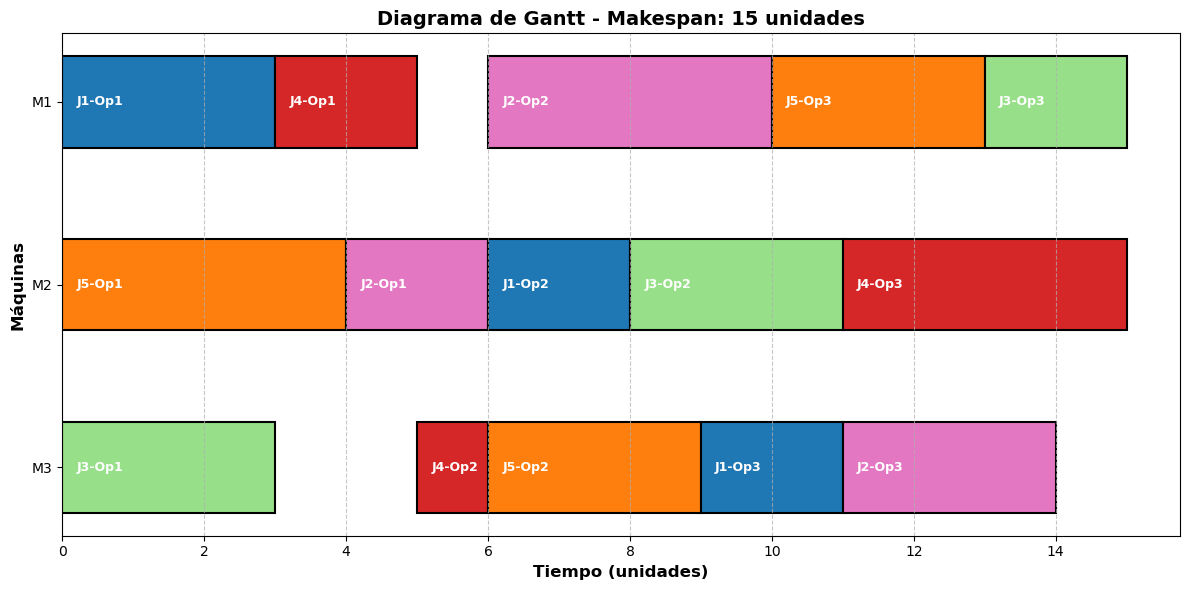

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ============================================================
# FUNCIÓN PARA DIBUJAR DIAGRAMA DE GANTT
# ============================================================

def plot_gantt(schedule):
    """
    Dibuja un diagrama de Gantt del cronograma.
    
    Args:
        schedule: Diccionario con tiempos de inicio y fin de cada operación
    """
    # Crear figura y ejes
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Paleta de colores para diferenciar trabajos
    colors = plt.cm.tab20.colors
    
    # Mapeo de máquinas a posición en el eje Y
    machine_y = {'M1': 3, 'M2': 2, 'M3': 1}
    
    # Para cada operación en el cronograma
    for i, ((job, op_idx), (start, end)) in enumerate(schedule.items()):
        # Obtener la máquina y duración de esta operación
        machine, duration = jobs[job][op_idx]
        
        # Obtener posición Y de esta máquina
        y = machine_y[machine]
        
        # Asignar color basado en el trabajo (mismo trabajo = mismo color)
        color = colors[hash(job) % len(colors)]
        
        # Dibujar barra horizontal para esta operación
        # - Ancho: duración (end - start)
        # - Posición inicial: start
        # - Altura Y: posición de la máquina
        ax.barh(y, end - start, left=start, height=0.5, 
                color=color, edgecolor='black', linewidth=1.5)
        
        # Añadir etiqueta de texto dentro de la barra
        ax.text(start + 0.2, y, f'{job}-Op{op_idx+1}', 
                va='center', ha='left', color='white', 
                fontsize=9, fontweight='bold')
    
    # Configurar ejes
    ax.set_yticks([1, 2, 3])
    ax.set_yticklabels(['M3', 'M2', 'M1'])
    ax.set_xlabel('Tiempo (unidades)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Máquinas', fontsize=12, fontweight='bold')
    ax.set_title(f'Diagrama de Gantt - Makespan: {makespan(schedule):.0f} unidades', 
                 fontsize=14, fontweight='bold')
    
    # Añadir grilla para facilitar lectura
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    
    # Ajustar diseño
    plt.tight_layout()
    plt.show()

# ============================================================
# MOSTRAR DIAGRAMA DE GANTT DE LA MEJOR SOLUCIÓN
# ============================================================

# Construir cronograma del mejor cromosoma
final_schedule = build_schedule(best_solution)

# Mostrar diagrama de Gantt
print("\nDiagrama de Gantt de la mejor solución:\n")
plot_gantt(final_schedule)

## Resumen de Conceptos

### Terminología de Algoritmos Genéticos:

| Concepto | En este problema | Ejemplo |
|----------|------------------|----------|
| **Gen** | Una operación específica | `('J1', 0)` - Operación 0 de J1 |
| **Cromosoma** | Orden completo de todas las operaciones | `[('J1',0), ('J2',0), ...]` |
| **Población** | Conjunto de cromosomas | 10-20 ordenes diferentes |
| **Fitness** | Negativo del makespan | -15 es mejor que -20 |
| **Generación** | Una iteración del algoritmo | Gen 1, Gen 2, ... |

### Operadores Genéticos:

1. **Selección:** Elegir padres con mejor fitness
2. **Cruce:** Combinar genes de dos padres
3. **Mutación:** Cambiar aleatoriamente el orden de genes

### Ventajas del Enfoque Genético:

✅ No requiere conocimiento específico del problema  
✅ Explora muchas soluciones simultáneamente  
✅ Balancea exploración y explotación  
✅ Puede encontrar soluciones de alta calidad  
✅ Paralelizable (cada individuo se puede evaluar independientemente)

### Aplicaciones del Job Shop Scheduling:

- Manufactura y producción
- Planificación de proyectos
- Asignación de recursos
- Logística y transporte
- Programación de tareas en computadoras

---

**¡Has completado el tutorial de Job Shop Scheduling con Algoritmos Genéticos!** 🎉